In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from rtma.imports import *
from rtma.core import *
from rtma.signal import *
from rtma.fft import *
from rtma.stft import *
from rtma.sine_model import *

In [3]:
import sys
sys.path.append('../software/models/')
import stft as STFT
import sineModel as SM
import utilFunctions as UF

In [4]:
path = "../sounds/flute-A4.wav"

In [5]:
x1, sr1 = load_audio(path)
sr2, x2 = UF.wavread(path)
assert sr1 == sr2
assert np.array_equal(x1, x2)

In [6]:
n_fft = 1024
n_hop = 150
n_window = 601
window_name = 'blackman'

In [7]:
x = x1
w = get_cola_window('blackman', n_window, n_hop)

### STFT

In [8]:
spectrum = list(stft(x, n_fft, n_hop, w, pad_center=True))
mx1, px1 = (np.stack(s) for s in zip(*spectrum))
mx2, px2 = STFT.stftAnal(x, w, n_fft, n_hop)

In [9]:
mx1.shape, mx2.shape

((635, 513), (633, 513))

In [10]:
mx1 = mx2[:mx1.shape[0]]
px1 = px2[:px1.shape[0]]
assert np.isclose(mx1, mx2).all()
assert np.isclose(px1, px2).all()

### Sine Model

In [11]:
mx, px = mx1, px1
sr = sr1

In [12]:
peak_thresh = -80
min_sine_duration = 0.1
max_n_sines = 150
max_plot_freq = 5000

In [13]:
tfreq, tmag, tphase = SM.sineModelAnal(x, 
                                       fs=sr,
                                       w=w, 
                                       N=n_fft, 
                                       H=n_hop,
                                       t=peak_thresh, 
                                       maxnSines=max_n_sines,
                                       minSineDur=min_sine_duration)

In [14]:
def plot_sines(mx: np.ndarray,
               tfreq: np.ndarray,
               max_plot_freq: int,
               n_fft: int,
               n_hop: int,
               sample_rate: int,
               figsize=(12, 6)):
    n_bins = int(n_fft*max_plot_freq/sample_rate) + 1
    n_frames = mx.shape[0]
    
    frame_times = np.arange(n_frames) / sample_rate * n_hop
    bin_freqs = np.arange(n_bins) * sample_rate / n_fft
    
    tracks = tfreq * np.less(tfreq, max_plot_freq)
    tracks[tracks <= 0] = np.nan
    
    plt.figure(figsize=figsize)
    plt.pcolormesh(frame_times, bin_freqs, mx.T[:n_bins])
    plt.plot(frame_times, tracks, c='k', lw=1.5)
    plt.tight_layout()
    plt.show()

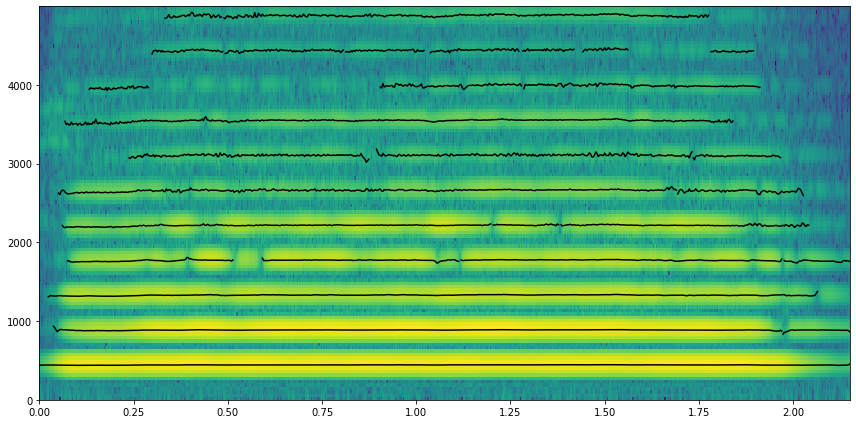

In [15]:
plot_sines(mx, tfreq, max_plot_freq, n_fft, n_hop, sr)

In [16]:
i = 10
mf = mx[i]
pf = px[i]

### Peak Locations

In [17]:
def plot_ipeaks(mags, ipeak_i, ipeak_mag, peak_i=None, t=None):
    plt.figure(figsize=(10, 4))
    plt.plot(mags)
    plt.plot(ipeak_i, ipeak_mag, marker='x', color='g', linestyle='', markeredgewidth=1.5)
    if peak_i is not None:
        plt.plot(peak_i, mags[peak_i], marker='x', color='r', linestyle='', markeredgewidth=1.5)
    if t is not None:
        plt.axhline(t, c='g')

In [18]:
peak_loc1 = UF.peakDetection(mf, t=peak_thresh)
ipeak_loc1, ipeak_mag1, ipeak_phase1 = UF.peakInterp(mX=mf,
                                                     pX=pf, 
                                                     ploc=peak_loc1)

(array([10, 31, 76, 82, 86]),
 array([10.2502, 30.653 , 76.4366, 82.1183, 86.2196]),
 array([-45.3265, -72.535 , -69.3427, -76.1365, -75.8812]),
 array([ 1.4766,  1.408 , -3.6018, -1.5007, -2.5145]))

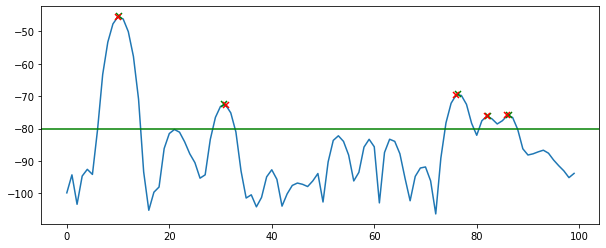

In [19]:
plot_ipeaks(mf[:100], ipeak_loc1, ipeak_mag1, peak_loc1, t=peak_thresh)
peak_loc1, ipeak_loc1, ipeak_mag1, ipeak_phase1

In [20]:
peak_loc2 = detect_peaks(mf, thresh=peak_thresh)
ipeak_loc2, ipeak_mag2 = interpolate_peaks(mf, peak_loc2)
ipeak_phase2 = np.interp(ipeak_loc2, np.arange(pf.size), pf)

In [21]:
assert np.array_equal(peak_loc1, peak_loc2)
assert np.array_equal(ipeak_loc1, ipeak_loc2)
assert np.array_equal(ipeak_mag1, ipeak_mag2)
assert np.array_equal(ipeak_phase1, ipeak_phase2)

### Sine Tracking

In [22]:
freq_dev_offset = 20
freq_dev_slope = 0.01
n_frames = 10

In [25]:
tfreq = np.array([])

for i, (mf, pf) in enumerate(zip(mx, px)):
    ploc = detect_peaks(mf, thresh=peak_thresh)
    iloc, imag = interpolate_peaks(mf, ploc)
    
    ifreq = sr * iloc / n_fft
    iphase = np.interp(iloc, np.arange(pf.size), pf)

    tfreq, tmag, tphase = SM.sineTracking(ifreq, imag, iphase, tfreq,
                                          freqDevOffset=freq_dev_offset,
                                          freqDevSlope=freq_dev_slope)
    
    if i < n_frames:
        print(tfreq)

[433.256]
[ 440.7793 3241.5822   98.7921 2277.8584]
[ 440.6939 3235.0458    0.        0.    ]
[ 440.8235 3250.3998 3651.1754    0.    ]
[ 441.8072 3232.3845 3669.4725 2267.2642]
[ 441.2655 3257.1133 3652.2638 2259.9188]
[ 441.3125 3238.0006 3671.9715    0.    ]
[ 442.0521 3283.1735 3665.5468 1306.5506]
[ 441.7442 3312.8506 3694.9633 1318.5989  906.8659]
[ 441.5071 3271.5543 3740.4632 1323.2356    0.     3461.7309]


In [26]:
tfreq = np.array([])

for i, (mf, pf) in enumerate(zip(mx, px)):
    ploc = detect_peaks(mf, thresh=peak_thresh)
    iloc, imag = interpolate_peaks(mf, ploc)
    
    ifreq = sr * iloc / n_fft
    iphase = np.interp(iloc, np.arange(pf.size), pf)

    frame = Frame(ifreq, imag, iphase)
    tframe = sine_tracking(frame, tfreq, 
                           freq_dev_offset=freq_dev_offset,
                           freq_dev_slope=freq_dev_slope)
    tfreq = tframe.freqs
    
    if i < n_frames:
        print(tfreq)

[433.256]
[ 440.7793 3241.5822   98.7921 2277.8584]
[ 440.6939 3235.0458    0.        0.    ]
[ 440.8235 3250.3998    0.        0.    ]
[ 441.8072 3232.3845    0.        0.    ]
[ 441.2655 3257.1133    0.        0.    ]
[ 441.3125 3238.0006    0.        0.    ]
[ 442.0521 3283.1735    0.        0.    ]
[ 441.7442 3312.8506 3694.9633 1318.5989  906.8659]
[ 441.5071 3271.5543 3740.4632 1323.2356    0.     3461.7309]
